In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, f1_score, ConfusionMatrixDisplay, \
classification_report, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# Learning history plotting function
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [3]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics for a model
def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model', ):
  ## Train
  mae = mean_absolute_error(y_train, pipe.predict(x_train))
  mse = mean_squared_error(y_train, pipe.predict(x_train))
  rmse = np.sqrt(mean_squared_error(y_train, pipe.predict(x_train)))
  r2 = r2_score(y_train, pipe.predict(x_train))
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  ## Test
  mae = mean_absolute_error(y_test, pipe.predict(x_test))
  mse = mean_squared_error(y_test, pipe.predict(x_test))
  rmse = np.sqrt(mean_squared_error(y_test, pipe.predict(x_test)))
  r2 = r2_score(y_test, pipe.predict(x_test))

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [4]:
# Get data
df = pd.read_csv(r"F:\Coding Dojo\Data\train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Cleaning Data

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
df.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [8]:
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [9]:
#added this to see all the columns in describe
pd.set_option('display.max_columns', None)

In [10]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
df.drop(columns=['Id'])

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,

In [12]:
## Print the unique values for the column
print('Unique Alley:\n', df['Alley'].unique())
print('\n')
## Print the unique values for the column
print('Unique Fireplace:\n', df['FireplaceQu'].unique())
print('\n')
## Print the unique values for the column
print('Unique Pool QC types:\n', df['PoolQC'].unique())
print('\n')
## Print the unique values for the column
print('Unique Fence types:\n', df['Fence'].unique())
print('\n')
## Print the unique values for the column
print('Unique Misc Feature types:\n', df['MiscFeature'].unique())
print('\n')

Unique Alley:
 [nan 'Grvl' 'Pave']


Unique Fireplace:
 [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']


Unique Pool QC types:
 [nan 'Ex' 'Fa' 'Gd']


Unique Fence types:
 [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


Unique Misc Feature types:
 [nan 'Shed' 'Gar2' 'Othr' 'TenC']




In [13]:
ka_df= df.copy()

### Preprocessing

In [14]:
#Target
target = 'SalePrice'
X = ka_df.drop(columns = [target])
y = ka_df[target]

In [15]:
# Split train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
#Set the Instantiate, Imputers, Transformers, Tupils and Pipelines.
#Used the mean imputer for the missing number values and I did not use an imputer for the object columns because we don't have any missing data there.
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include= 'object')

mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='drop')
preprocessor.fit(X_train)

X_train_proc = preprocessor.transform(X_train)
X_test_proc= preprocessor.transform(X_test)

X_train_proc.shape

(1095, 285)

In [17]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed[:5]

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (1095, 285)




array([[ 0.69831455,  1.47591094, -1.20217378, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.19637178, -0.87122795,  0.33376282, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.54902506, -0.16708628, -0.45614743, ...,  0.        ,
         1.        ,  0.        ],
       [-0.23723136, -0.87122795,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.20344139, -0.87122795,  0.20211112, ...,  0.        ,
         1.        ,  0.        ]])

In [18]:
shape_input = X_train_proc.shape[1]

### Decision Tree Regression Pipe

In [19]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=42)
reg_pipe=make_pipeline(preprocessor, reg_tree)


In [20]:
reg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000028B316C0340>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                          

In [21]:
#Changed the parameters for grid search
dec_param_grid = {'decisiontreeregressor__max_depth': range(1,10),
                  'decisiontreeregressor__max_leaf_nodes': range(1,10)}

In [22]:
#Gridsearched for the best parameters with the parameters I requested.
dec_pipe_gs = GridSearchCV(reg_pipe, dec_param_grid)

dec_pipe_gs.fit(X_train, y_train)
print('Best Decision Tree Regressor Parameters:')
print(dec_pipe_gs.best_params_)
dec_best_pipe = dec_pipe_gs.best_estimator_
print(f'Accuracy of best Decision Tree Regressor model is: {dec_best_pipe.score(X_test, y_test)}')

Best Decision Tree Regressor Parameters:
{'decisiontreeregressor__max_depth': 3, 'decisiontreeregressor__max_leaf_nodes': 8}
Accuracy of best Decision Tree Regressor model is: 0.7722039584752491


C:\Users\miran\anaconda3\envs\dojo-env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\miran\anaconda3\envs\dojo-env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\miran\anaconda3\envs\dojo-env\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\miran\anaconda3\envs\dojo-env\lib\site-packages\sklearn\tree\_classes.py", line 1342, in fit
    su

In [23]:
dec_best_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028B3187B430>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028B3187BDF0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=3, max_leaf_nodes=8,
                                       random_state=42))])

In [24]:
dec_train_preds = dec_best_pipe.predict(X_train)
dec_test_preds = dec_best_pipe.predict(X_test)

In [25]:
# evaluate the model
dec_train_score = dec_best_pipe.score(X_train, y_train)
dec_test_score = dec_best_pipe.score(X_test, y_test)
print(dec_train_score)
print(dec_test_score)

0.7324146385696486
0.7722039584752491


### Bias and Variance

In [70]:
# create model architecture
reg_model = Sequential()
 
reg_model.add(Dense(10, input_dim=shape_input, activation='relu'))
reg_model.add(Dense(5, activation='relu'))
reg_model.add(Dense(1, activation='linear'))
 
reg_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 10)                2860      
                                                                 
 dense_40 (Dense)            (None, 5)                 55        
                                                                 
 dense_41 (Dense)            (None, 1)                 6         
                                                                 
Total params: 2,921
Trainable params: 2,921
Non-trainable params: 0
_________________________________________________________________


In [71]:
# compile model with additional metrics
reg_model.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

In [72]:
history_ac = reg_model.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs=200,
                        verbose=0)

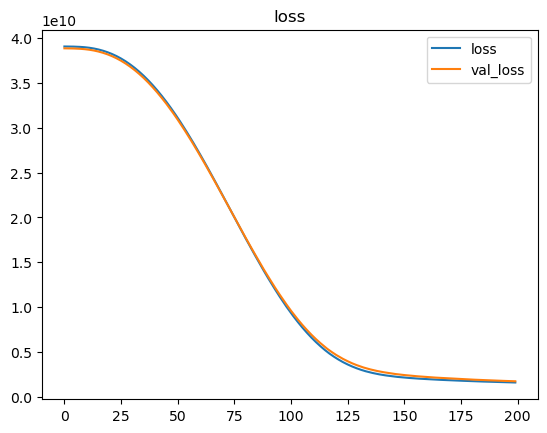

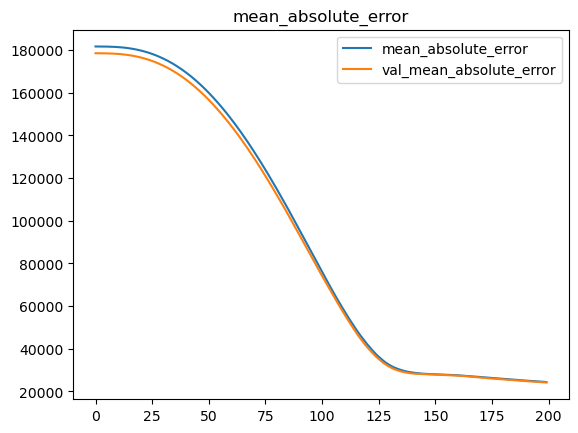

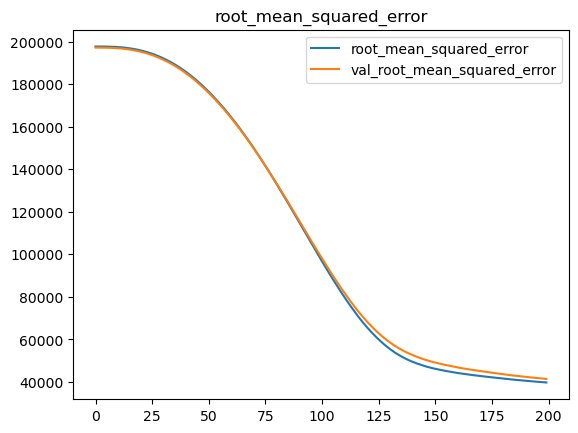

In [73]:
# plot learning
plot_history(history)

In [74]:
# evaluate model

y_pred = reg_model.predict(X_test_proc)

print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 868us/step
final RMSE: 41111.651537494516
final MAE: 24113.70571489726
final R2: 0.758730431518083


### Drop

In [91]:
# With dropout
# Sequential model
drop_model = Sequential()
# First hidden layer
drop_model.add(Dense(10,
                input_dim = shape_input,
                activation = 'relu'))
drop_model.add(Dropout(0.2))
drop_model.add(Dense(5, activation = 'relu'))
drop_model.add(Dropout(0.2))
drop_model.add(Dense(1, activation = 'relu'))

In [92]:
# compile model with additional metrics
drop_model.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

In [93]:
history_drop = drop_model.fit(X_train_processed, y_train,
                    validation_data = (X_test_processed, y_test), 
                    epochs=200)

Epoch 1/200
35/35 [==============================] - 1s 6ms/step - loss: 39090495488.0000 - mean_absolute_error: 181711.4531 - root_mean_squared_error: 197713.1719 - val_loss: 38883942400.0000 - val_mean_absolute_error: 178545.9688 - val_root_mean_squared_error: 197190.1250
Epoch 2/200
35/35 [==============================] - 0s 2ms/step - loss: 39089451008.0000 - mean_absolute_error: 181708.7500 - root_mean_squared_error: 197710.5156 - val_loss: 38882660352.0000 - val_mean_absolute_error: 178542.5781 - val_root_mean_squared_error: 197186.8594
Epoch 3/200
35/35 [==============================] - 0s 2ms/step - loss: 39087869952.0000 - mean_absolute_error: 181704.6250 - root_mean_squared_error: 197706.5312 - val_loss: 38880395264.0000 - val_mean_absolute_error: 178536.5469 - val_root_mean_squared_error: 197181.1250
Epoch 4/200
35/35 [==============================] - 0s 2ms/step - loss: 39084466176.0000 - mean_absolute_error: 181695.6562 - root_mean_squared_error: 197697.9219 - val_loss:

Epoch 31/200
35/35 [==============================] - 0s 2ms/step - loss: 36434264064.0000 - mean_absolute_error: 174720.5156 - root_mean_squared_error: 190877.6094 - val_loss: 36160737280.0000 - val_mean_absolute_error: 171307.1719 - val_root_mean_squared_error: 190159.7656
Epoch 32/200
35/35 [==============================] - 0s 2ms/step - loss: 36159131648.0000 - mean_absolute_error: 173933.4062 - root_mean_squared_error: 190155.5469 - val_loss: 35917090816.0000 - val_mean_absolute_error: 170646.8750 - val_root_mean_squared_error: 189518.0469
Epoch 33/200
35/35 [==============================] - 0s 2ms/step - loss: 35871412224.0000 - mean_absolute_error: 173185.9688 - root_mean_squared_error: 189397.5000 - val_loss: 35666419712.0000 - val_mean_absolute_error: 169962.8438 - val_root_mean_squared_error: 188855.5469
Epoch 34/200
35/35 [==============================] - 0s 2ms/step - loss: 35625566208.0000 - mean_absolute_error: 172518.5469 - root_mean_squared_error: 188747.3594 - val_l

Epoch 61/200
35/35 [==============================] - 0s 2ms/step - loss: 25148493824.0000 - mean_absolute_error: 140361.6406 - root_mean_squared_error: 158582.7656 - val_loss: 24765943808.0000 - val_mean_absolute_error: 137268.0312 - val_root_mean_squared_error: 157371.9844
Epoch 62/200
35/35 [==============================] - 0s 2ms/step - loss: 24753772544.0000 - mean_absolute_error: 138675.0625 - root_mean_squared_error: 157333.3125 - val_loss: 24282073088.0000 - val_mean_absolute_error: 135645.7344 - val_root_mean_squared_error: 155827.0625
Epoch 63/200
35/35 [==============================] - 0s 2ms/step - loss: 24396408832.0000 - mean_absolute_error: 137743.7500 - root_mean_squared_error: 156193.5000 - val_loss: 23806257152.0000 - val_mean_absolute_error: 134030.5625 - val_root_mean_squared_error: 154292.7656
Epoch 64/200
35/35 [==============================] - 0s 2ms/step - loss: 23568281600.0000 - mean_absolute_error: 135251.6250 - root_mean_squared_error: 153519.6406 - val_l

Epoch 91/200
35/35 [==============================] - 0s 2ms/step - loss: 12503767040.0000 - mean_absolute_error: 86041.9688 - root_mean_squared_error: 111820.2422 - val_loss: 11043103744.0000 - val_mean_absolute_error: 81313.4062 - val_root_mean_squared_error: 105086.1719
Epoch 92/200
35/35 [==============================] - 0s 2ms/step - loss: 12030690304.0000 - mean_absolute_error: 83542.4766 - root_mean_squared_error: 109684.5000 - val_loss: 10687915008.0000 - val_mean_absolute_error: 79437.5859 - val_root_mean_squared_error: 103382.3750
Epoch 93/200
35/35 [==============================] - 0s 2ms/step - loss: 11461583872.0000 - mean_absolute_error: 82230.2969 - root_mean_squared_error: 107058.7891 - val_loss: 10331614208.0000 - val_mean_absolute_error: 77527.1719 - val_root_mean_squared_error: 101644.5469
Epoch 94/200
35/35 [==============================] - 0s 2ms/step - loss: 11689012224.0000 - mean_absolute_error: 80680.4844 - root_mean_squared_error: 108115.7344 - val_loss: 99

35/35 [==============================] - 0s 2ms/step - loss: 6713920512.0000 - mean_absolute_error: 59492.3320 - root_mean_squared_error: 81938.5156 - val_loss: 4362578944.0000 - val_mean_absolute_error: 38162.6133 - val_root_mean_squared_error: 66049.8203
Epoch 122/200
35/35 [==============================] - 0s 2ms/step - loss: 7363800064.0000 - mean_absolute_error: 62258.4414 - root_mean_squared_error: 85812.5859 - val_loss: 4259511296.0000 - val_mean_absolute_error: 37408.3984 - val_root_mean_squared_error: 65264.9297
Epoch 123/200
35/35 [==============================] - 0s 2ms/step - loss: 6863828992.0000 - mean_absolute_error: 60346.2617 - root_mean_squared_error: 82848.2266 - val_loss: 4162835968.0000 - val_mean_absolute_error: 36697.5391 - val_root_mean_squared_error: 64520.0430
Epoch 124/200
35/35 [==============================] - 0s 2ms/step - loss: 6556520448.0000 - mean_absolute_error: 58460.4297 - root_mean_squared_error: 80972.3438 - val_loss: 4086874624.0000 - val_mean

35/35 [==============================] - 0s 2ms/step - loss: 6410922496.0000 - mean_absolute_error: 58277.7031 - root_mean_squared_error: 80068.2344 - val_loss: 2904547328.0000 - val_mean_absolute_error: 28100.0898 - val_root_mean_squared_error: 53893.8516
Epoch 152/200
35/35 [==============================] - 0s 2ms/step - loss: 5997023232.0000 - mean_absolute_error: 57254.2812 - root_mean_squared_error: 77440.4531 - val_loss: 2885388288.0000 - val_mean_absolute_error: 27994.1699 - val_root_mean_squared_error: 53715.8086
Epoch 153/200
35/35 [==============================] - 0s 2ms/step - loss: 6432189440.0000 - mean_absolute_error: 57924.1445 - root_mean_squared_error: 80200.9297 - val_loss: 2870186752.0000 - val_mean_absolute_error: 27918.4688 - val_root_mean_squared_error: 53574.1250
Epoch 154/200
35/35 [==============================] - 0s 2ms/step - loss: 6574843904.0000 - mean_absolute_error: 59132.0352 - root_mean_squared_error: 81085.4141 - val_loss: 2849347328.0000 - val_mean

35/35 [==============================] - 0s 2ms/step - loss: 5905939968.0000 - mean_absolute_error: 55878.0820 - root_mean_squared_error: 76850.1172 - val_loss: 2508217856.0000 - val_mean_absolute_error: 26581.7285 - val_root_mean_squared_error: 50082.1094
Epoch 182/200
35/35 [==============================] - 0s 2ms/step - loss: 6195797504.0000 - mean_absolute_error: 56950.9453 - root_mean_squared_error: 78713.3906 - val_loss: 2487072768.0000 - val_mean_absolute_error: 26457.0078 - val_root_mean_squared_error: 49870.5586
Epoch 183/200
35/35 [==============================] - 0s 2ms/step - loss: 5946864640.0000 - mean_absolute_error: 56533.5430 - root_mean_squared_error: 77115.9141 - val_loss: 2499665408.0000 - val_mean_absolute_error: 26630.3477 - val_root_mean_squared_error: 49996.6523
Epoch 184/200
35/35 [==============================] - 0s 2ms/step - loss: 6222475264.0000 - mean_absolute_error: 56644.6719 - root_mean_squared_error: 78882.6641 - val_loss: 2494741248.0000 - val_mean

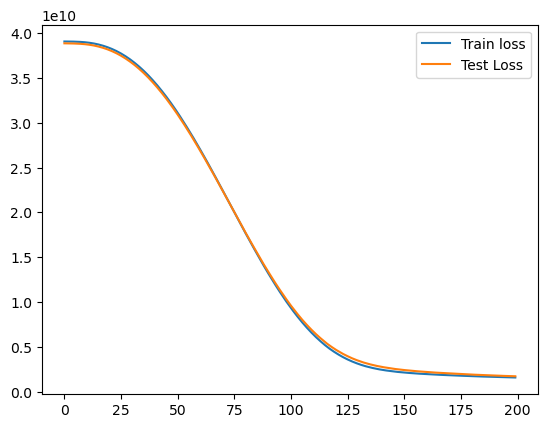

In [94]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

### Early Stop

In [96]:
from tensorflow.keras.callbacks import EarlyStopping
# With early stopping
# Sequential model
stop_model = Sequential()
# First hidden layer
stop_model.add(Dense(10,
                input_dim = shape_input,
                activation = 'relu'))
stop_model.add(Dense(5, 
                activation = 'relu'))
stop_model.add(Dense(1, activation = 'linear'))
# compile model with additional metrics
stop_model.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])
early_stopping = EarlyStopping(patience = 5)
history_drop = stop_model.fit(X_train_processed, y_train,
                    validation_data = (X_test_processed, y_test), 
                    epochs=200,
                    callbacks = [early_stopping])

Epoch 1/200
35/35 [==============================] - 0s 6ms/step - loss: 39090765824.0000 - mean_absolute_error: 181712.2344 - root_mean_squared_error: 197713.8438 - val_loss: 38884532224.0000 - val_mean_absolute_error: 178547.5781 - val_root_mean_squared_error: 197191.6094
Epoch 2/200
35/35 [==============================] - 0s 2ms/step - loss: 39090503680.0000 - mean_absolute_error: 181711.5469 - root_mean_squared_error: 197713.1875 - val_loss: 38884192256.0000 - val_mean_absolute_error: 178546.6562 - val_root_mean_squared_error: 197190.7500
Epoch 3/200
35/35 [==============================] - 0s 2ms/step - loss: 39090053120.0000 - mean_absolute_error: 181710.3281 - root_mean_squared_error: 197712.0469 - val_loss: 38883606528.0000 - val_mean_absolute_error: 178545.1562 - val_root_mean_squared_error: 197189.2656
Epoch 4/200
35/35 [==============================] - 0s 2ms/step - loss: 39089250304.0000 - mean_absolute_error: 181708.3125 - root_mean_squared_error: 197710.0156 - val_loss:

Epoch 31/200
35/35 [==============================] - 0s 2ms/step - loss: 37484634112.0000 - mean_absolute_error: 177533.3281 - root_mean_squared_error: 193609.4844 - val_loss: 37238951936.0000 - val_mean_absolute_error: 174236.2812 - val_root_mean_squared_error: 192973.9688
Epoch 32/200
35/35 [==============================] - 0s 2ms/step - loss: 37324537856.0000 - mean_absolute_error: 177111.8281 - root_mean_squared_error: 193195.5938 - val_loss: 37079134208.0000 - val_mean_absolute_error: 173812.1719 - val_root_mean_squared_error: 192559.4375
Epoch 33/200
35/35 [==============================] - 0s 2ms/step - loss: 37155639296.0000 - mean_absolute_error: 176664.3594 - root_mean_squared_error: 192757.9844 - val_loss: 36908544000.0000 - val_mean_absolute_error: 173359.4219 - val_root_mean_squared_error: 192115.9688
Epoch 34/200
35/35 [==============================] - 0s 2ms/step - loss: 36977328128.0000 - mean_absolute_error: 176194.2031 - root_mean_squared_error: 192294.9062 - val_l

Epoch 61/200
35/35 [==============================] - 0s 2ms/step - loss: 29052688384.0000 - mean_absolute_error: 153855.0156 - root_mean_squared_error: 170448.4844 - val_loss: 28901265408.0000 - val_mean_absolute_error: 150645.2031 - val_root_mean_squared_error: 170003.7188
Epoch 62/200
35/35 [==============================] - 0s 1ms/step - loss: 28659679232.0000 - mean_absolute_error: 152660.6562 - root_mean_squared_error: 169291.7031 - val_loss: 28511100928.0000 - val_mean_absolute_error: 149456.2969 - val_root_mean_squared_error: 168852.3125
Epoch 63/200
35/35 [==============================] - 0s 1ms/step - loss: 28256591872.0000 - mean_absolute_error: 151436.5781 - root_mean_squared_error: 168096.9688 - val_loss: 28114356224.0000 - val_mean_absolute_error: 148241.1562 - val_root_mean_squared_error: 167673.3594
Epoch 64/200
35/35 [==============================] - 0s 1ms/step - loss: 27849054208.0000 - mean_absolute_error: 150183.3438 - root_mean_squared_error: 166880.3594 - val_l

Epoch 91/200
35/35 [==============================] - 0s 2ms/step - loss: 16112821248.0000 - mean_absolute_error: 108541.6484 - root_mean_squared_error: 126936.2891 - val_loss: 16229271552.0000 - val_mean_absolute_error: 105994.9453 - val_root_mean_squared_error: 127394.1562
Epoch 92/200
35/35 [==============================] - 0s 2ms/step - loss: 15686686720.0000 - mean_absolute_error: 106759.6250 - root_mean_squared_error: 125246.5000 - val_loss: 15811905536.0000 - val_mean_absolute_error: 104238.3047 - val_root_mean_squared_error: 125745.3984
Epoch 93/200
35/35 [==============================] - 0s 2ms/step - loss: 15265217536.0000 - mean_absolute_error: 104955.6797 - root_mean_squared_error: 123552.4922 - val_loss: 15395935232.0000 - val_mean_absolute_error: 102460.1406 - val_root_mean_squared_error: 124080.3594
Epoch 94/200
35/35 [==============================] - 0s 2ms/step - loss: 14845305856.0000 - mean_absolute_error: 103162.7578 - root_mean_squared_error: 121841.3125 - val_l

Epoch 121/200
35/35 [==============================] - 0s 2ms/step - loss: 5943331840.0000 - mean_absolute_error: 54510.4453 - root_mean_squared_error: 77093.0078 - val_loss: 6286360576.0000 - val_mean_absolute_error: 53144.4453 - val_root_mean_squared_error: 79286.5703
Epoch 122/200
35/35 [==============================] - 0s 2ms/step - loss: 5725801472.0000 - mean_absolute_error: 52938.7656 - root_mean_squared_error: 75669.0234 - val_loss: 6068186112.0000 - val_mean_absolute_error: 51553.2266 - val_root_mean_squared_error: 77898.5625
Epoch 123/200
35/35 [==============================] - 0s 2ms/step - loss: 5515191808.0000 - mean_absolute_error: 51423.1328 - root_mean_squared_error: 74264.3359 - val_loss: 5864960000.0000 - val_mean_absolute_error: 50044.6211 - val_root_mean_squared_error: 76583.0234
Epoch 124/200
35/35 [==============================] - 0s 2ms/step - loss: 5314526208.0000 - mean_absolute_error: 49926.9297 - root_mean_squared_error: 72900.7969 - val_loss: 5667220992.0

35/35 [==============================] - 0s 2ms/step - loss: 2438495744.0000 - mean_absolute_error: 28831.1055 - root_mean_squared_error: 49381.1289 - val_loss: 2762893312.0000 - val_mean_absolute_error: 28409.6758 - val_root_mean_squared_error: 52563.2305
Epoch 152/200
35/35 [==============================] - 0s 2ms/step - loss: 2400715520.0000 - mean_absolute_error: 28707.4766 - root_mean_squared_error: 48997.0977 - val_loss: 2717885440.0000 - val_mean_absolute_error: 28340.6758 - val_root_mean_squared_error: 52133.3438
Epoch 153/200
35/35 [==============================] - 0s 2ms/step - loss: 2362227456.0000 - mean_absolute_error: 28589.7246 - root_mean_squared_error: 48602.7500 - val_loss: 2677607168.0000 - val_mean_absolute_error: 28288.3730 - val_root_mean_squared_error: 51745.6016
Epoch 154/200
35/35 [==============================] - 0s 2ms/step - loss: 2328188672.0000 - mean_absolute_error: 28485.8320 - root_mean_squared_error: 48251.3086 - val_loss: 2639369984.0000 - val_mean

35/35 [==============================] - 0s 2ms/step - loss: 1852170496.0000 - mean_absolute_error: 26962.0781 - root_mean_squared_error: 43036.8516 - val_loss: 2061153024.0000 - val_mean_absolute_error: 26732.2500 - val_root_mean_squared_error: 45399.9219
Epoch 182/200
35/35 [==============================] - 0s 2ms/step - loss: 1841513728.0000 - mean_absolute_error: 26871.2246 - root_mean_squared_error: 42912.8633 - val_loss: 2047979520.0000 - val_mean_absolute_error: 26634.5449 - val_root_mean_squared_error: 45254.6094
Epoch 183/200
35/35 [==============================] - 0s 2ms/step - loss: 1830438912.0000 - mean_absolute_error: 26780.6484 - root_mean_squared_error: 42783.6289 - val_loss: 2034493184.0000 - val_mean_absolute_error: 26554.9648 - val_root_mean_squared_error: 45105.3555
Epoch 184/200
35/35 [==============================] - 0s 2ms/step - loss: 1819709824.0000 - mean_absolute_error: 26720.2012 - root_mean_squared_error: 42658.0586 - val_loss: 2019567104.0000 - val_mean

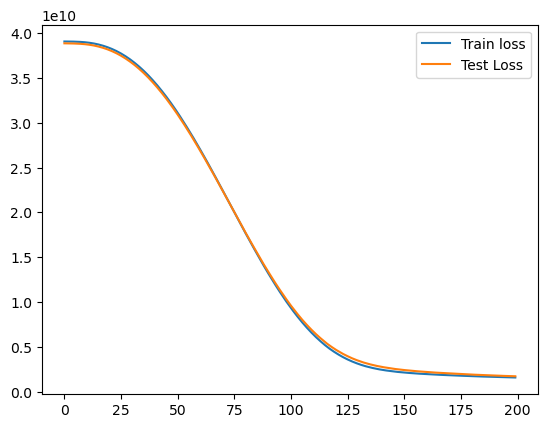

In [90]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.legend();

## I like the stop early model for larger data set. It gives you the appropriate information with the shortest amount of time. If it was a smaller dataset I would have liked to work with Bias and Variance model just to play with it more but when time is priority using stop early or drop works better.